(example_02_synthetic_natural_image_patches)=

# Synthetic Natural Image Patches

This notebook demonstrates the application of `circle_bundles` to a synthetic dataset of high-contrast $n\times n$ optical image patches sampled from a known model with the topology of a Klein bottle embedded in $\mathbb{R}^{n^{2}}$ (see --). 

We choose an $\mathbb{RP}^{1}$-valued feature map and model the dataset as a discrete approximate circle bundle.  We compute characteristic classes to confirm the non-orientable global topology of the underlying model, then construct a coordinate system which reflects the inherent non-orientability. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ripser import ripser
from persim import plot_diagrams

import circle_bundles as cb

Generate the dataset and treat patches as vectors in $\mathbb{R}^{n^{2}}$

In [2]:
n_img_patches = 5000  
n_img = 3   #Choose a patch size

rng = np.random.default_rng(0)
img_data = cb.sample_nat_img_kb(n_img_patches, n = n_img, rng = rng)[0]  

#Create a patch visualizer function
patch_vis = cb.make_patch_visualizer()

Compute the predominant gradient direction of each patch

In [3]:
grad_dirs = cb.get_gradient_dirs(img_data)[0]   

View a small random sample of the dataset arranged by gradient direction

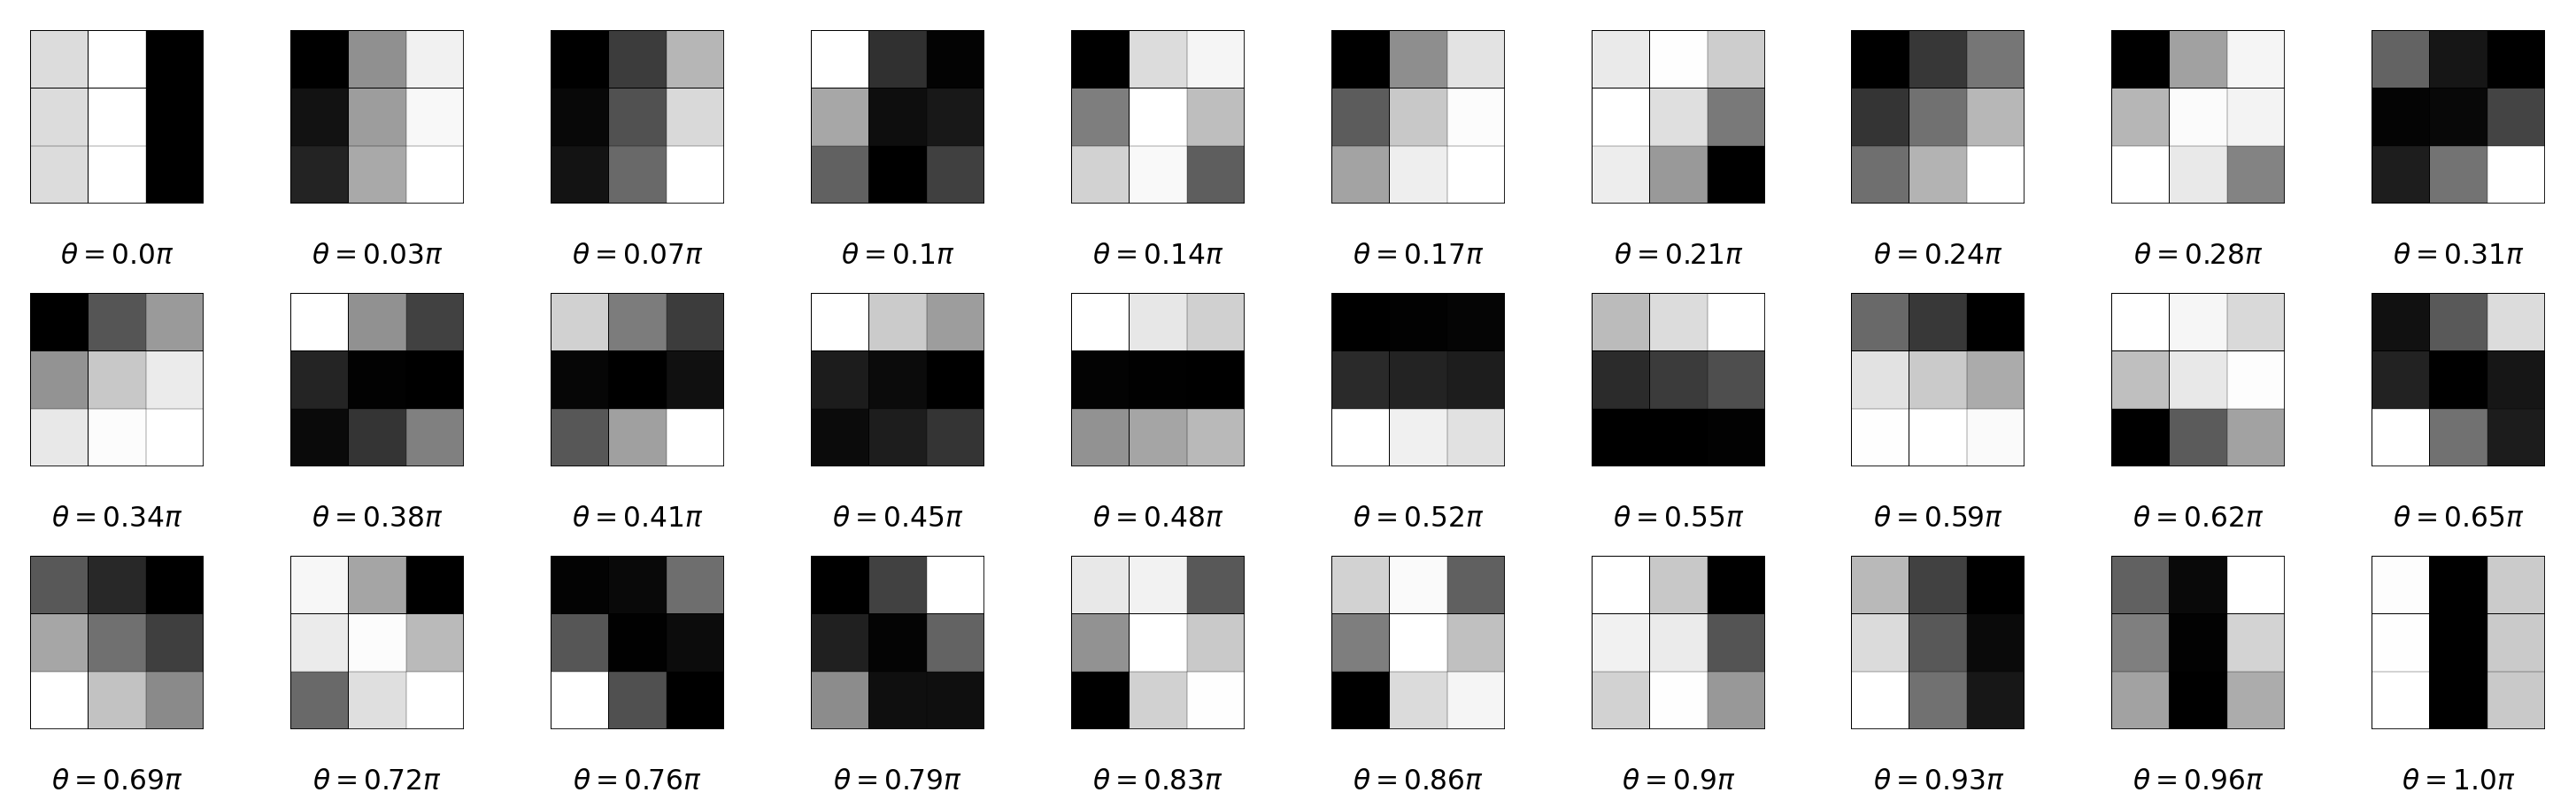

In [4]:
n_samples = 30

label_func = [fr"$\theta = {np.round(grad/np.pi, 2)}$" + r"$\pi$" for grad in grad_dirs]

fig = cb.show_data_vis(
    img_data, 
    patch_vis, 
    label_func = label_func, 
    angles = grad_dirs, 
    sampling_method = 'angle', 
    max_samples = n_samples)
plt.show()


Compute persistence diagrams over $\mathbb{Z}_{2}$ and $\mathbb{Z}_{3}$ for a sample of the dataset


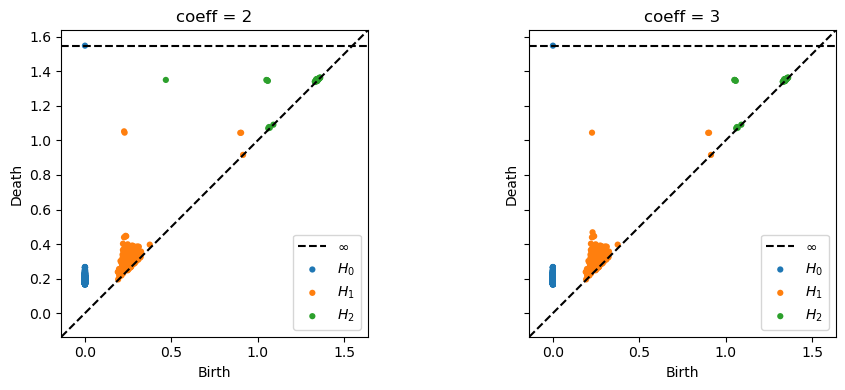

In [5]:
dgms_2 = ripser(img_data, coeff=2, maxdim=2, n_perm=500)["dgms"]
dgms_3 = ripser(img_data, coeff=3, maxdim=2, n_perm=500)["dgms"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

plot_diagrams(dgms_2, ax=axes[0], title="coeff = 2")
plot_diagrams(dgms_3, ax=axes[1], title="coeff = 3")

plt.tight_layout()
plt.show()


Note the $\mathbb{Z}_{2}$ diagram has two 1-dimensional persistent classes and one 2-dimensional persistent class, but the $\mathbb{Z}_{3}$ diagram has a single 1-dimensional persistent classes and no 2-dimensional persistent classes. This is consistent with the homology of the Klein bottle, as expected. 

To apply local-to-global analysis, we construct a cover of the base space $\mathbb{RP}^{1}$ by metric balls $\{U_{j}\}$ around equally-spaced landmarks. 

### Cover And Nerve Summary
- $n_\text{sets} = 12$, $n_\text{samples} = 5000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 12$
- $\#(\text{1-simplices}) = 12$
- *No recorded simplices in dimensions* $\ge 2$

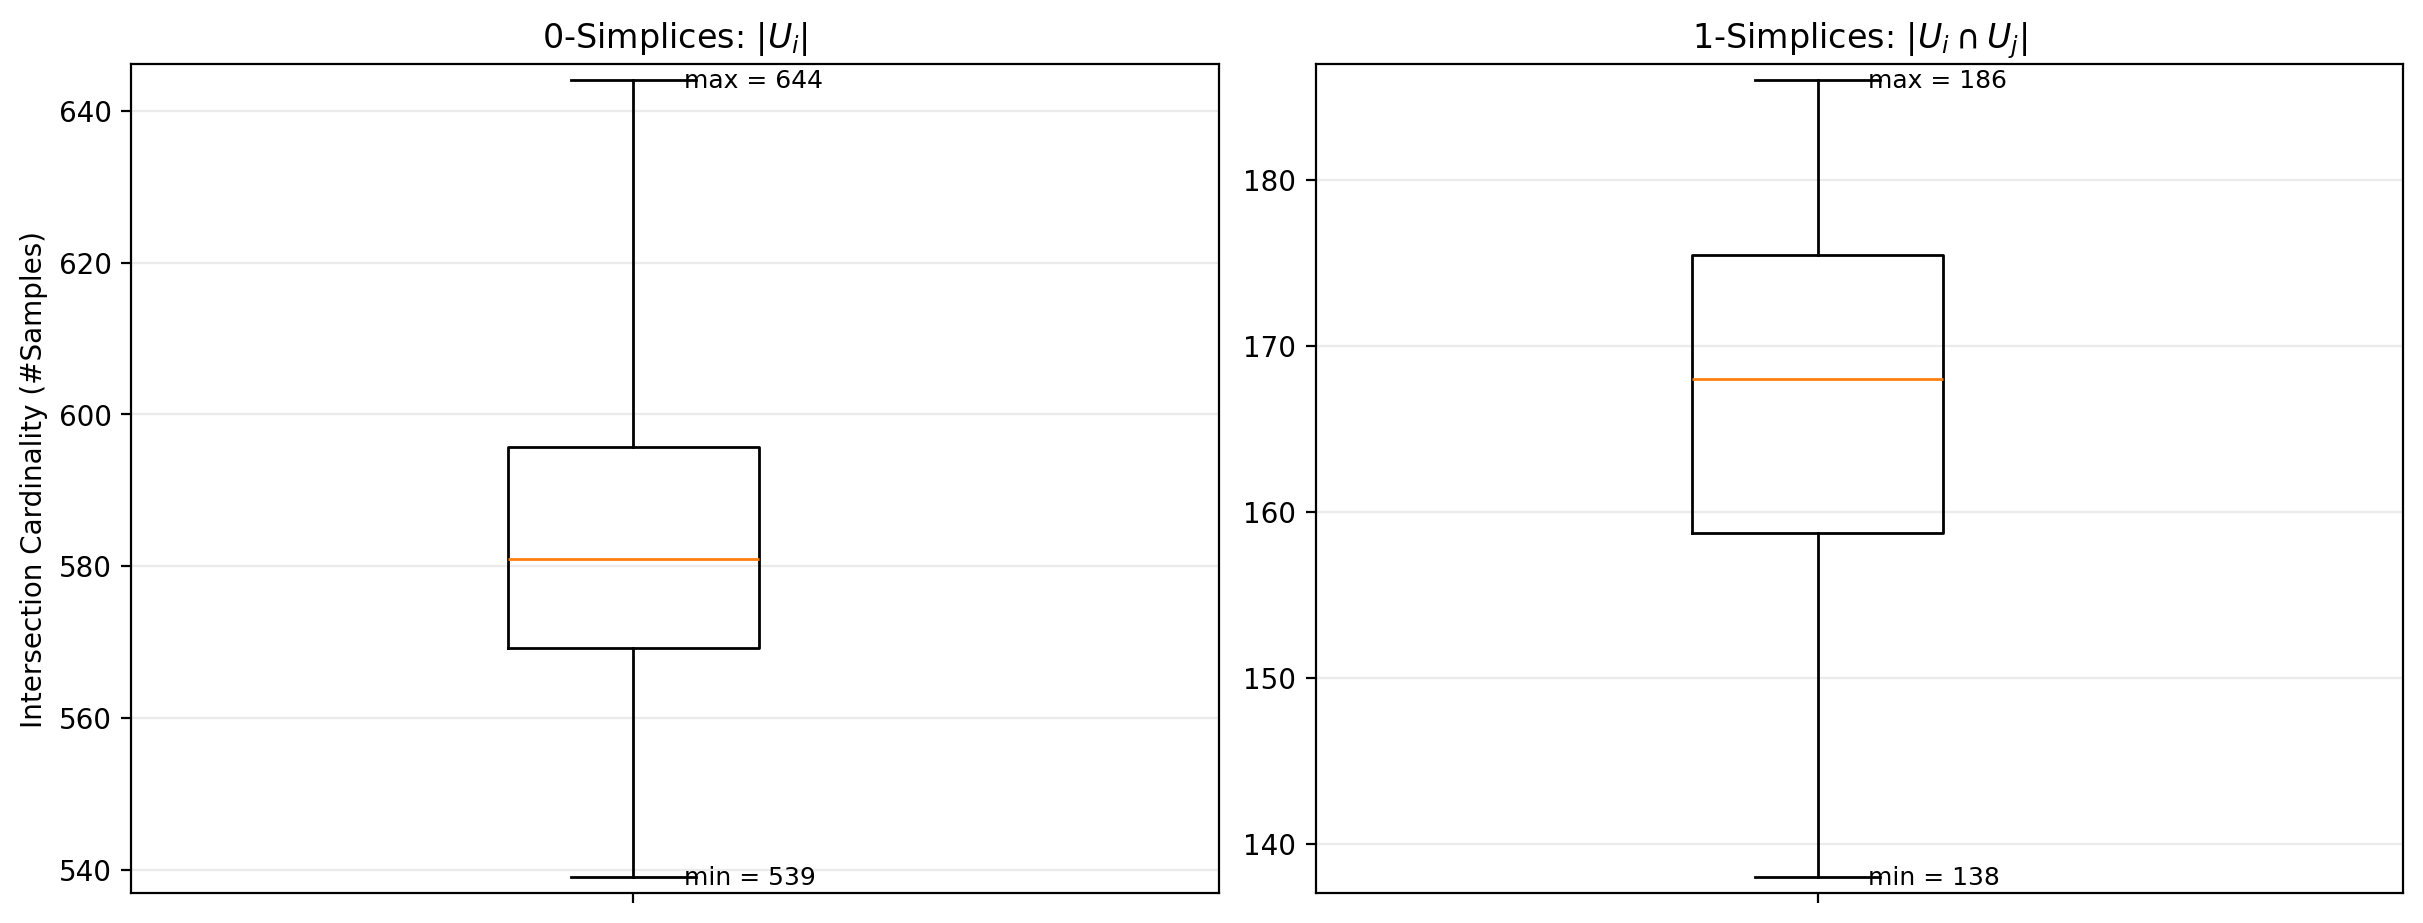

In [7]:
n_img_landmarks = 12
img_landmarks = np.linspace(0, np.pi,n_img_landmarks, endpoint= False)
img_overlap = 1.4

img_radius = img_overlap* np.pi/(2*n_img_landmarks)

img_cover = cb.MetricBallCover(grad_dirs, 
                               img_landmarks, 
                               img_radius, 
                               metric = cb.RP1AngleMetric())

img_cover_data = img_cover.build()

img_summ = img_cover.summarize(plot=True) 
plt.show()

Compute a persistence diagram for the data in each set $\pi^{-1}(U_{j})$

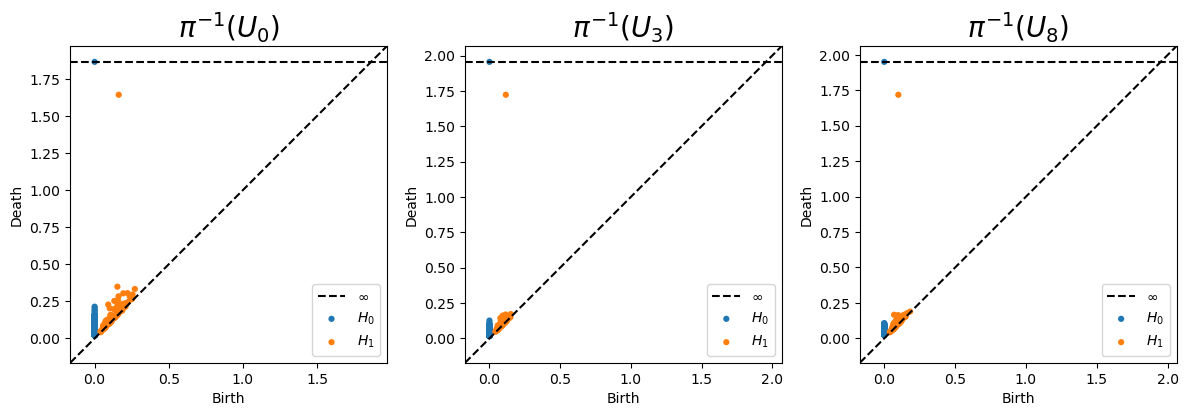

In [8]:
fiber_ids, dense_idx_list, rips_list = cb.get_local_rips(
    img_data,
    img_cover.U,
    p_values=None,
    to_view = [0,3,8], #Choose a few diagrams to compute 
                       #(or compute all by setting to None)
    maxdim=1,
    n_perm=500,
    random_state=None,
)

fig, axes = cb.plot_local_rips(
    fiber_ids,
    rips_list,
    n_cols=3,
    titles='default',
    font_size=20,
)

Observe that each $\pi^{-1}(U_{j})$ has a single 1-dimensional (circular) persistent feature, supporting the hypothesis that the data has the structure of a discrete approximate circle bundle over $\mathbb{RP}^{1}$. Up to isomorphism, the only circle bundles over $\mathbb{RP}^{1}\cong\mathbb{S}^{1}$ are the torus (trivial) and the Klein bottle (non-orientable). These two possibilities are distinguished by their orientation class $w_{1}$.

Construct a bundle object to compute local circular coordinates, approximate transition matrices and characteristic classes: 

In [9]:
img_bundle = cb.build_bundle(
    img_data,
    img_cover,
    show=True,
)

<IPython.core.display.Math object>

Our bundle analysis confirms the non-trivial global structure, so a global trivialization is not possible here. Instead, we remove an edge from the nerve of the open cover (corresponding to the set intersection with the poorest Procrustes alignment quality), and compute coordinates which reflect this cut.  

In [10]:
img_triv_result = img_bundle.get_global_trivialization()

Show a visualization of the nerve of the open cover with edges decorated by the values of the computed orientation cocycle representative (shown in blue).  The 'weight' assigned to each edge, measuring the quality of Procrustes alignment on the corresponding set intersection, is shown. The edge which was removed for coordinatization is indicated, and a potential for the orientation cocycle after restriction to the reduced nerve is shown in red. 

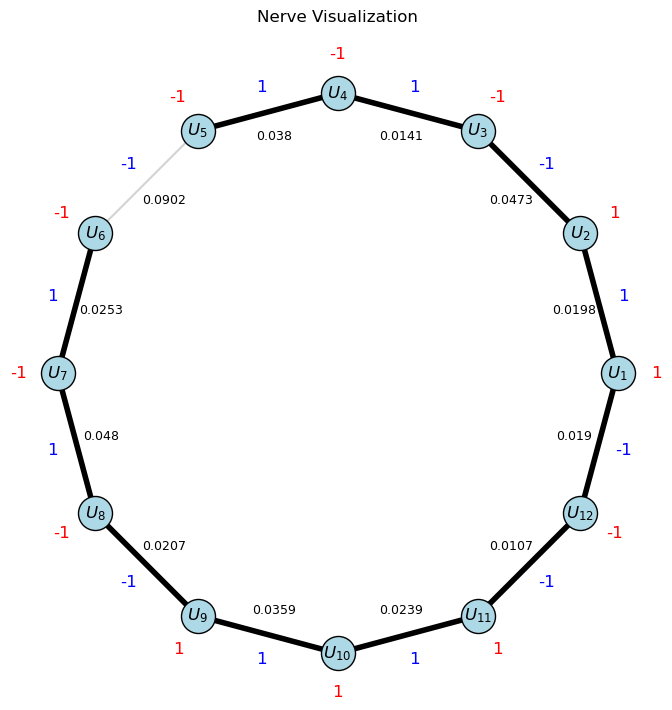

In [11]:
fig = img_bundle.show_circle_nerve()

plt.show()

Now, show a sample of coordinatized patches from the dataset:

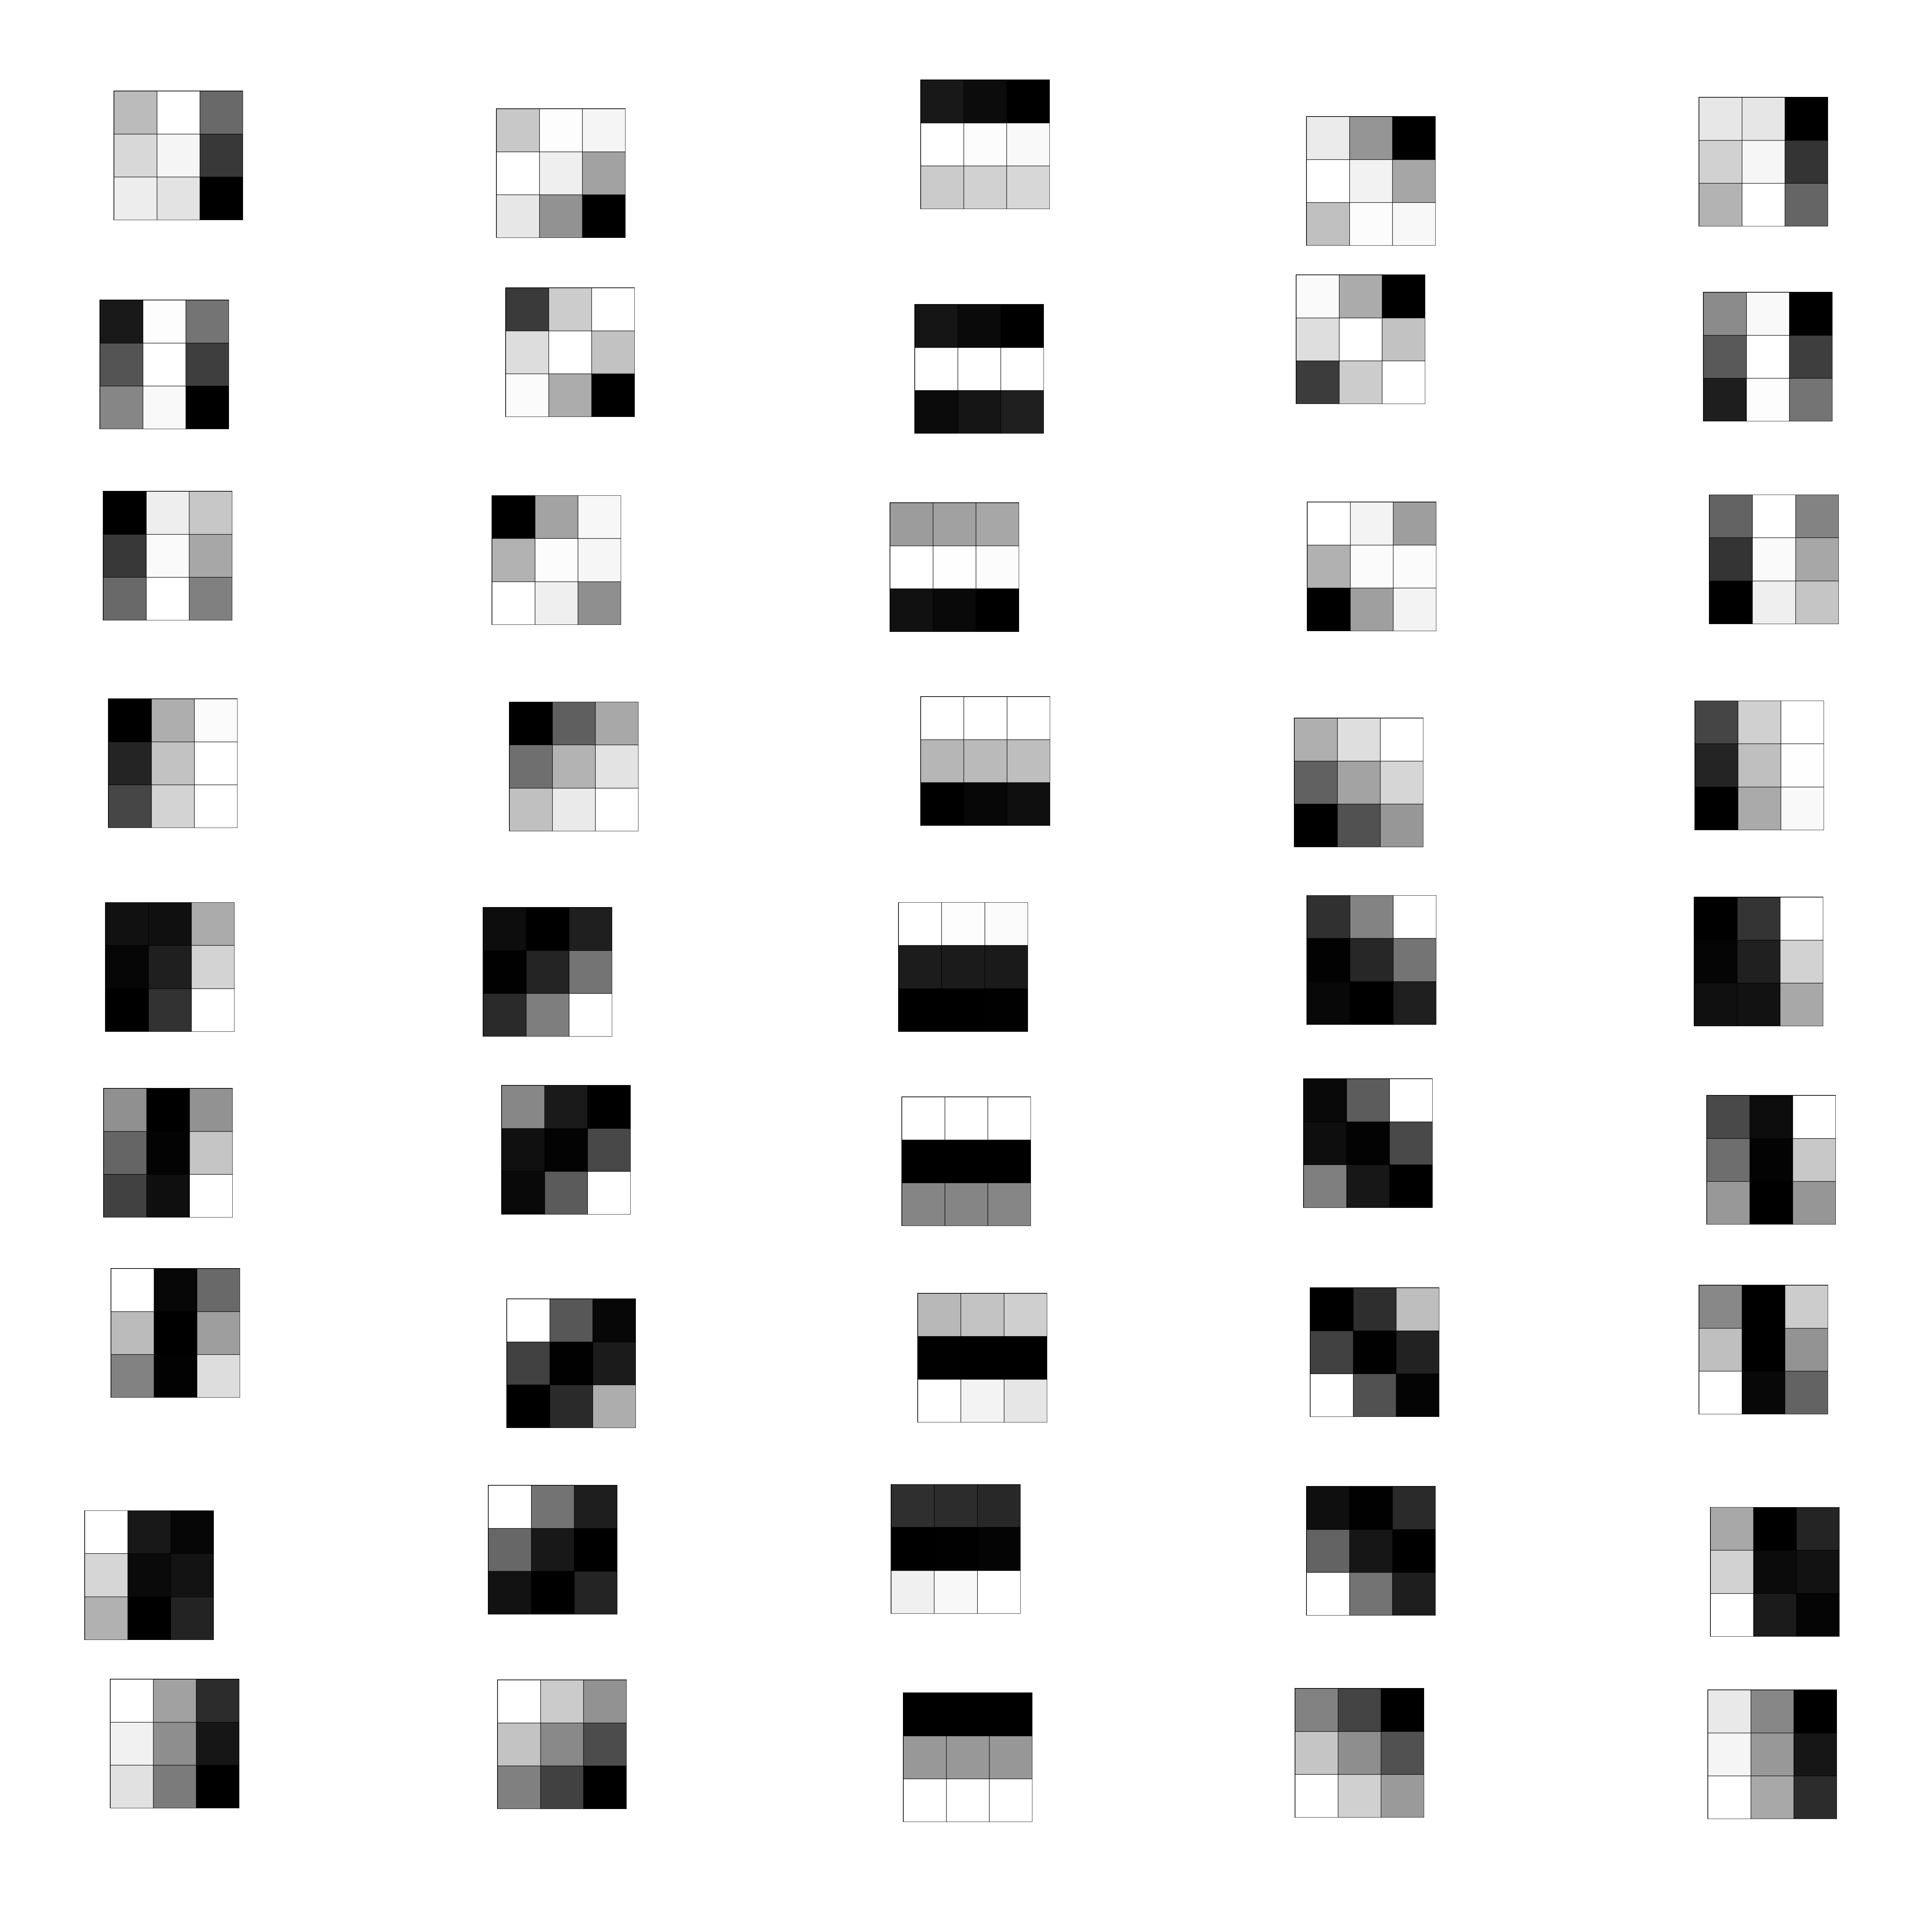

In [12]:
per_row = 5
per_col = 9
coords = np.column_stack([grad_dirs.reshape(-1,1), img_triv_result.F.reshape(-1,1)])

fig = cb.lattice_vis(
    img_data,
    coords,
    patch_vis,
    per_row=per_row,
    per_col = per_col,
    figsize=19,
    thumb_px=350,   
    dpi=350         
)

plt.show()


Notice the abrupt reflection in the coordinates between columns 2 and 3 in the diagram above.  